In [1]:
import geopandas as gpd
import numpy as np

In [2]:
# Read file
crashes_index = gpd.read_file("data/crashes_index.geojson")
crashes_index. info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   FIPS                  992 non-null    object  
 1   area_sq_km            992 non-null    float64 
 2   crash_count           992 non-null    float64 
 3   Total population      992 non-null    int32   
 4   crash_density         992 non-null    float64 
 5   Shannon_Wiener_Index  992 non-null    float64 
 6   geometry              992 non-null    geometry
dtypes: float64(4), geometry(1), int32(1), object(1)
memory usage: 50.5+ KB


In [3]:
# Read file
crashes_age = gpd.read_file("data/crashes_age.geojson")
crashes_age. info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   FIPS                  992 non-null    object  
 1   area_sq_km            992 non-null    float64 
 2   crash_count           992 non-null    float64 
 3   Total population      992 non-null    int32   
 4   crash_density         992 non-null    float64 
 5   Weighted Average Age  992 non-null    float64 
 6   geometry              992 non-null    geometry
dtypes: float64(4), geometry(1), int32(1), object(1)
memory usage: 50.5+ KB


In [4]:
# Read file
crashes_mi = gpd.read_file("data/crashes_mi.geojson")
crashes_mi. info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   FIPS              978 non-null    object  
 1   area_sq_km        978 non-null    float64 
 2   crash_count       978 non-null    float64 
 3   Total population  978 non-null    int32   
 4   crash_density     978 non-null    float64 
 5   Median Income     978 non-null    float64 
 6   geometry          978 non-null    geometry
dtypes: float64(4), geometry(1), int32(1), object(1)
memory usage: 49.8+ KB


In [5]:
# Merge data
merged_data = crashes_index[["FIPS", "crash_count", "crash_density", "Shannon_Wiener_Index", "geometry"]].merge(
    crashes_age[["FIPS", "Weighted Average Age"]], on="FIPS", how="inner"
)

merged_data = merged_data.merge(
    crashes_mi[["FIPS", "Median Income"]], on="FIPS", how="inner"
)

merged_data = merged_data.dropna()
merged_data. info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   FIPS                  978 non-null    object  
 1   crash_count           978 non-null    float64 
 2   crash_density         978 non-null    float64 
 3   Shannon_Wiener_Index  978 non-null    float64 
 4   geometry              978 non-null    geometry
 5   Weighted Average Age  978 non-null    float64 
 6   Median Income         978 non-null    float64 
dtypes: float64(5), geometry(1), object(1)
memory usage: 53.6+ KB


In [6]:
# Conduct multivariate regression analysis 
import statsmodels.api as sm

predictors = ["Median Income", "Weighted Average Age", "Shannon_Wiener_Index"]
target = "crash_density"

X = merged_data[predictors]
Y = merged_data[target]

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          crash_density   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.379
Date:                Mon, 17 Mar 2025   Prob (F-statistic):             0.0178
Time:                        11:55:48   Log-Likelihood:                -1364.1
No. Observations:                 978   AIC:                             2736.
Df Residuals:                     974   BIC:                             2756.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.3201 

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

model_poly = sm.OLS(Y, sm.add_constant(X_poly)).fit()
print(model_poly.summary())

                            OLS Regression Results                            
Dep. Variable:          crash_density   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.373
Date:                Mon, 17 Mar 2025   Prob (F-statistic):             0.0118
Time:                        11:55:48   Log-Likelihood:                -1358.5
No. Observations:                 978   AIC:                             2737.
Df Residuals:                     968   BIC:                             2786.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1322      1.655      3.706      0.0

In [8]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

ridge.fit(X, Y)
lasso.fit(X, Y)

print(f"R^2 Score (Ridge): {ridge.score(X, Y):.4f}")
print(f"R^2 Score (Lasso): {lasso.score(X, Y):.4f}")

R^2 Score (Ridge): 0.0103
R^2 Score (Lasso): 0.0010


In [9]:
# Train Random Forest model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, Y)

print(f"R^2 Score (Random Forest): {rf.score(X, Y):.4f}")

R^2 Score (Random Forest): 0.8791


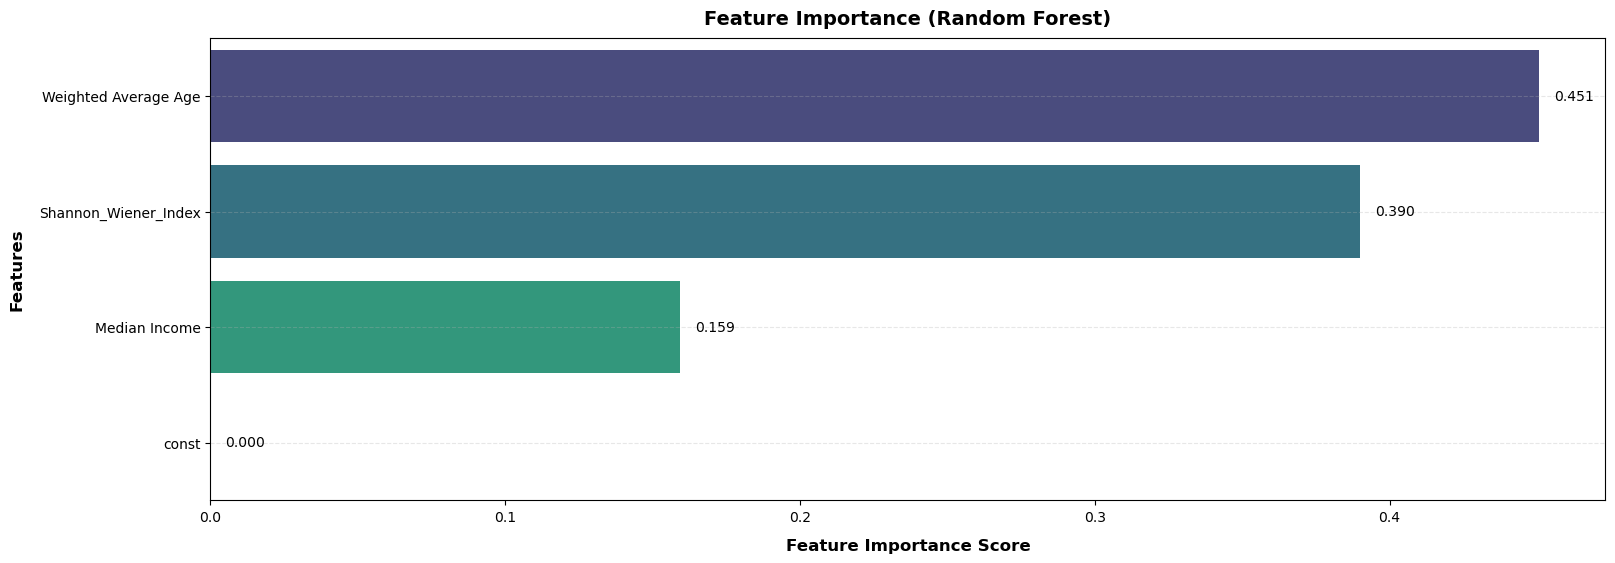

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_rf = rf.feature_importances_
features_rf = X.columns

indices = np.argsort(feature_importance_rf)[::-1]

plt.figure(figsize=(18,6))
sns.barplot(x=feature_importance_rf[indices], 
            y=features_rf[indices], 
            hue=features_rf[indices],
            dodge=False,
            palette="viridis",
            legend=False)

for i, v in enumerate(feature_importance_rf[indices]):
    plt.text(v + 0.005, i, f"{v:.3f}", fontsize=10, verticalalignment="center")

plt.xlabel("Feature Importance Score", fontsize=12, fontweight='bold', labelpad = 10)
plt.ylabel("Features", fontsize=12, fontweight='bold', labelpad = 10)
plt.title("Feature Importance (Random Forest)", fontsize=14, fontweight='bold', pad = 10)
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.savefig("Feature Importance (Random Forest).png", dpi=300, bbox_inches="tight")

plt.show()

In [11]:
# Conduct cross-validation
from sklearn.ensemble import GradientBoostingRegressor

gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbdt.fit(X, Y)

print(f"R^2 Score (GBDT): {gbdt.score(X, Y):.4f}")

R^2 Score (GBDT): 0.9026


/tmp/ipykernel_3535/1833526390.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_gbdt[indices], y=features_gbdt[indices], palette="viridis", hue=None)


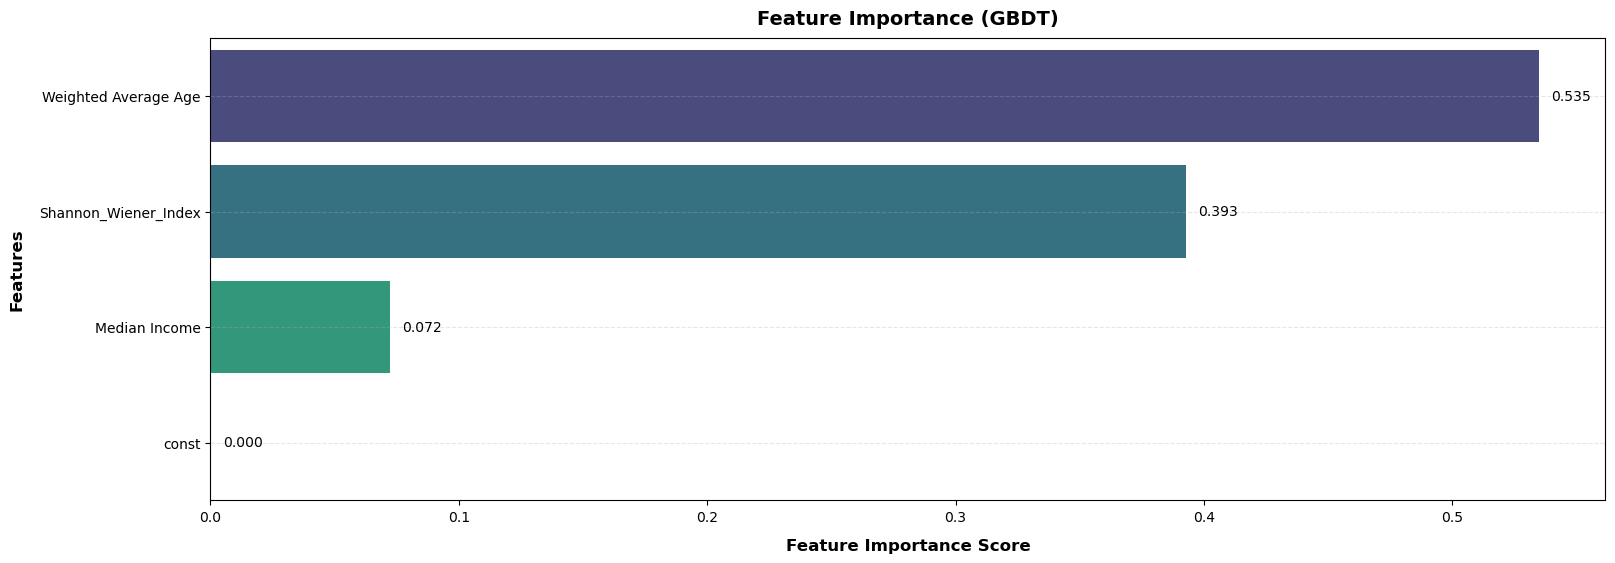

In [12]:
feature_importance_gbdt = gbdt.feature_importances_
features_gbdt = X.columns

indices = np.argsort(feature_importance_gbdt)[::-1]

plt.figure(figsize=(18, 6))
sns.barplot(x=feature_importance_gbdt[indices], y=features_gbdt[indices], palette="viridis", hue=None)

for i, v in enumerate(feature_importance_gbdt[indices]):
    plt.text(v + 0.005, i, f"{v:.3f}", fontsize=10, verticalalignment="center")

plt.xlabel("Feature Importance Score", fontsize=12, fontweight='bold', labelpad = 10)
plt.ylabel("Features", fontsize=12, fontweight='bold', labelpad = 10)
plt.title("Feature Importance (GBDT)", fontsize=14, fontweight='bold', pad = 10)
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.savefig("Feature Importance (GBDT).png", dpi=300, bbox_inches="tight")

plt.show()